# Stellar Classification

Stellar classification model implemented with Random Forest Classifier.

### Libraries

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import metrics
# Our modules
import metrics_tools
import models_testing
import scaling

## Data Preprocessing

In the original dataset, the **class column** (which is our target vector) is placed in the center of the dataframe, so it's necessary to palce it as the last column before applying further processing.

In [3]:
df = pd.read_csv("dataset/star_classification.csv")
df = df[["obj_ID", "alpha", "delta", "u", "g", "r", "i", "z", "run_ID", "rerun_ID", "cam_col", "field_ID", "spec_obj_ID", "redshift", "plate", "MJD", "fiber_ID", "class"]]
df.head() # Show 4 top rows

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID,class
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,0.634794,5812,56354,171,GALAXY
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,0.779136,10445,58158,427,GALAXY
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,0.644195,4576,55592,299,GALAXY
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,0.932346,9149,58039,775,GALAXY
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,0.116123,6121,56187,842,GALAXY


In [4]:
label_encoder = LabelEncoder()
label_encoder.fit(df["class"])
df["class"] = label_encoder.transform(df["class"])

### Discarding features

Not all features will be useful for the classification task. In order to select only the most infarentials ones, the first step is analyzing the **linear correlation** between them and the **Variance Inflation Factor**.

#### Correlation Matrix

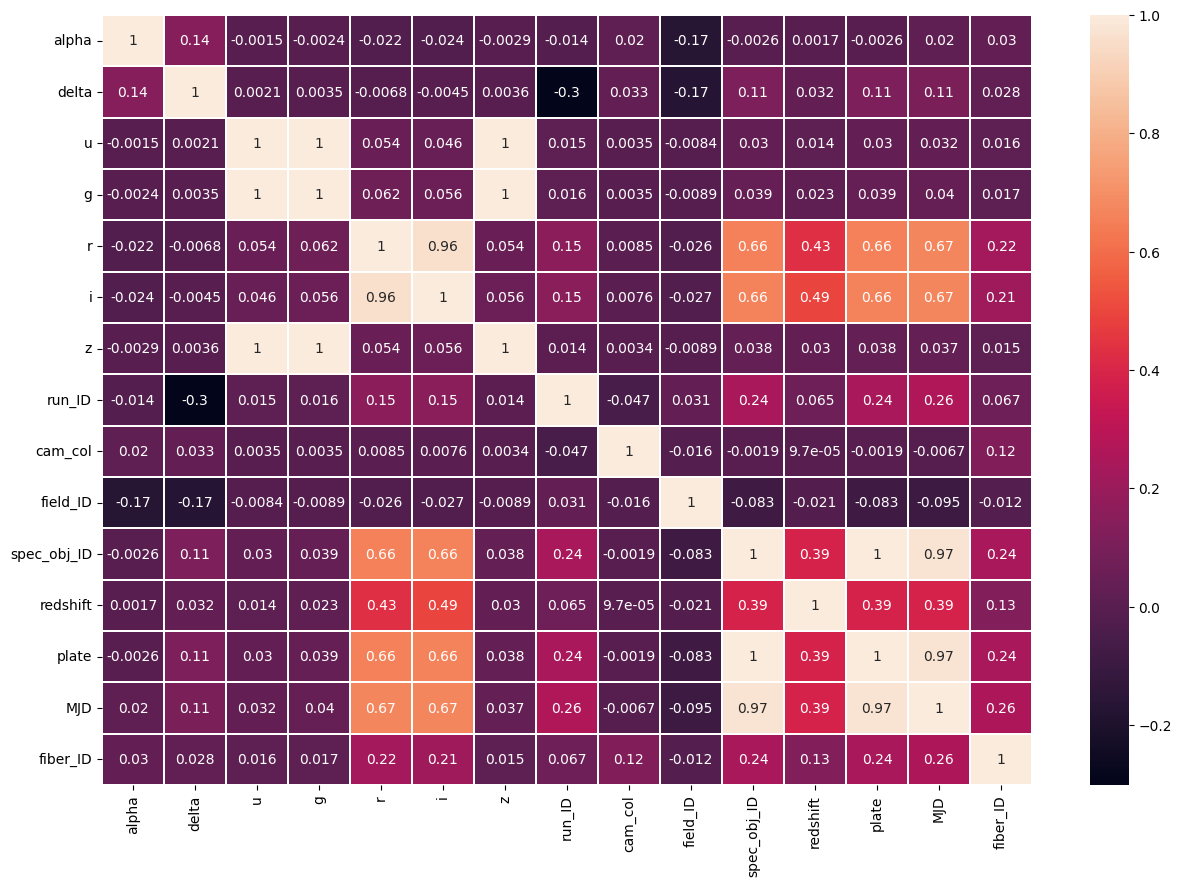

In [5]:
metrics_tools.corr_matrix(df.drop(["class", "obj_ID", "rerun_ID"], axis = 1).corr())
# we discard also "rerun_ID" as takes a constant value for each sample

#### Variance Inflation Factor (VIF)

In [6]:
metrics_tools.variance_inflation(df)

/Users/genna/.pyenv/versions/acsai/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


       Variable           VIF
0        obj_ID  5.612779e-10
1         alpha  1.000006e+00
2         delta  1.012774e+00
3             u  1.000901e+00
4             g  1.001558e+00
5             r  1.752373e+00
6             i  1.778624e+00
7             z  1.001432e+00
8        run_ID  1.060856e+00
9      rerun_ID  0.000000e+00
10      cam_col  1.000002e+00
11     field_ID  1.007017e+00
12  spec_obj_ID  2.351782e+02
13     redshift  1.177915e+00
14        plate  2.090999e+09
15          MJD  1.701719e+01
16     fiber_ID  1.061814e+00
17        class  1.000101e+00


The most concerning VIF degree, is happening with the ```plate``` variable, so its deletion is necessary.

#### Restricted Feature Space

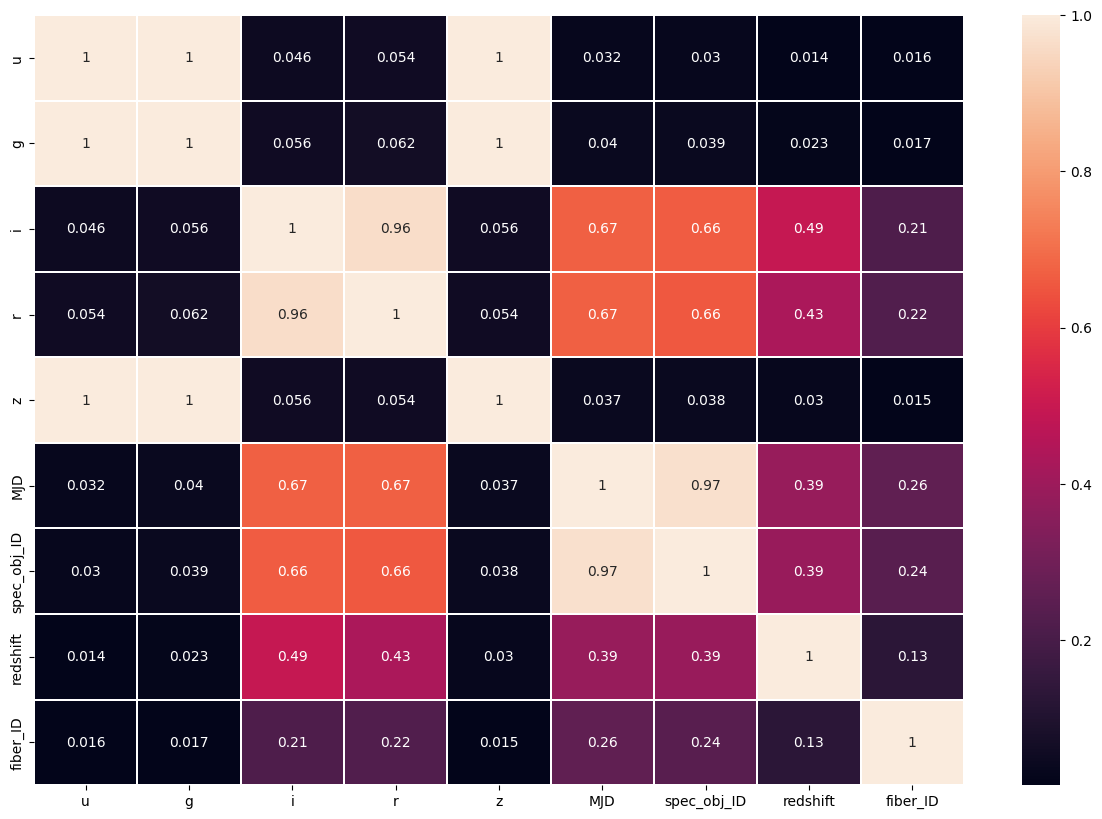

In [7]:
features = [# List of features with stronger degree of linear correlation to keep in the dataframe
    "u",    # Ultraviolet filter in the photometric system
    "g",    # Green filter in the photometric system
    "i",    # Near Infrared filter in the photometric system
    "r",    # Red filter in the photometric system
    "z",    # Infrared filter in the photometric system
    "MJD",  # Modified Julian Date
    "spec_obj_ID", # Unique ID used for optical spectroscopic objects
    "redshift", # Redshift value based on the increase in wavelength
    "fiber_ID", # Fiber ID that identifies the fiber that pointed the light at the focal plane in each observation
    "class" # Object class
          ]
df = df[features]
metrics_tools.corr_matrix(df.drop(["class"], axis=1).corr())

### Dataset scaling and balancing
Before taking data to the model, it's necessary to **scale the dataset** (i.e. standardize the data through z-score transformation) in order to reduce the gap between orders of magnitude for each feature to make them comparable. <br>
Furthermore, to ensure balance in the dataset, we apply [SMOTE-Tomek](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html) hybrid sampling.

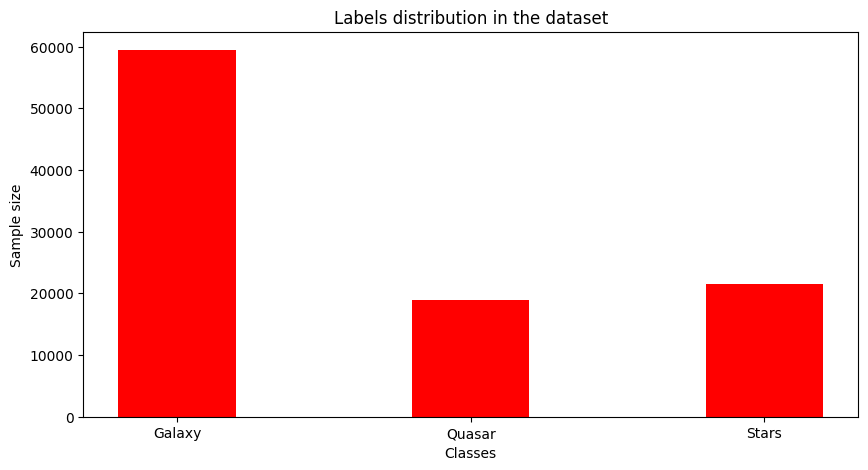

In [8]:
metrics_tools.plotLabels(df["class"]) # Shows severe imbalance between classes

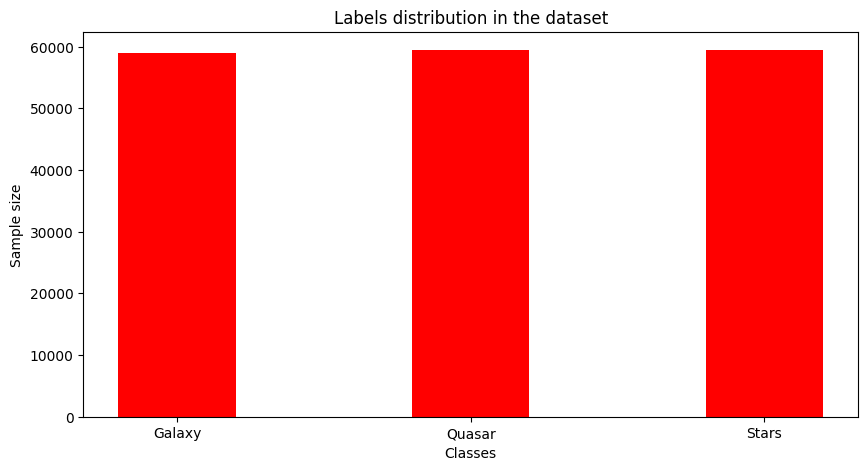

In [9]:
data, X, y = scaling.scale_dataset(df) # Pass balance=False to unable hybrid sampling
metrics_tools.plotLabels(y)

### Train and Test sets

The dataset gets splitted into training and test sets. The distribution of the total data is respectively 75%-25%. Note that, <u>using random forest classifier, we will NOT need an additional validation set.</u> <br>

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Principal Component Analysis (PCA)

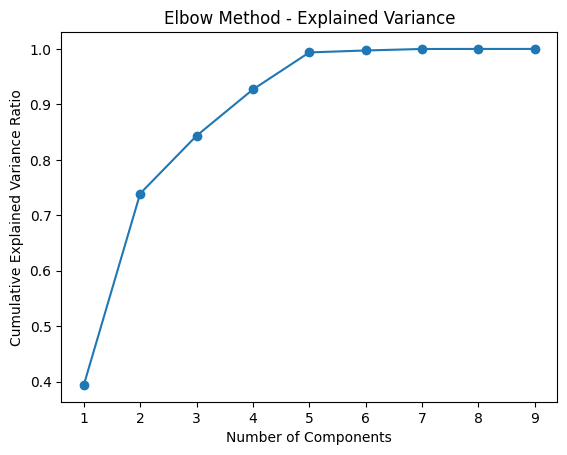

In [11]:
metrics_tools.plot_pca_elbow(X)

In [13]:
pca = PCA(n_components=9) # To adjust based on the above plot
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

## Random Forest and Decision Trees

### Impurity functions

In order to make the model determine the optimal way to partition the data, **impurity functions** are needed. Here both **Entropy** and **Gini impurity** will be computed.

#### Entropy

$$ H(X) = -\sum_{x \in X} p(x) \log_2(p(x)) $$

In [14]:
entropy_vals = metrics_tools.entropy(y_train)
print(-sum(entropy_vals))

1.5849617477717095


#### Gini impurity

$$ Gini(X) = 1-\sum_{x \in X} p(x)^2$$

In [15]:
gini_vals = metrics_tools.gini_impurity(y_train)
print(1-sum(gini_vals))

0.6666663188109585


### Random Forest

In order to find the optimal hyperparameters for the model, **grid search** must be performed.

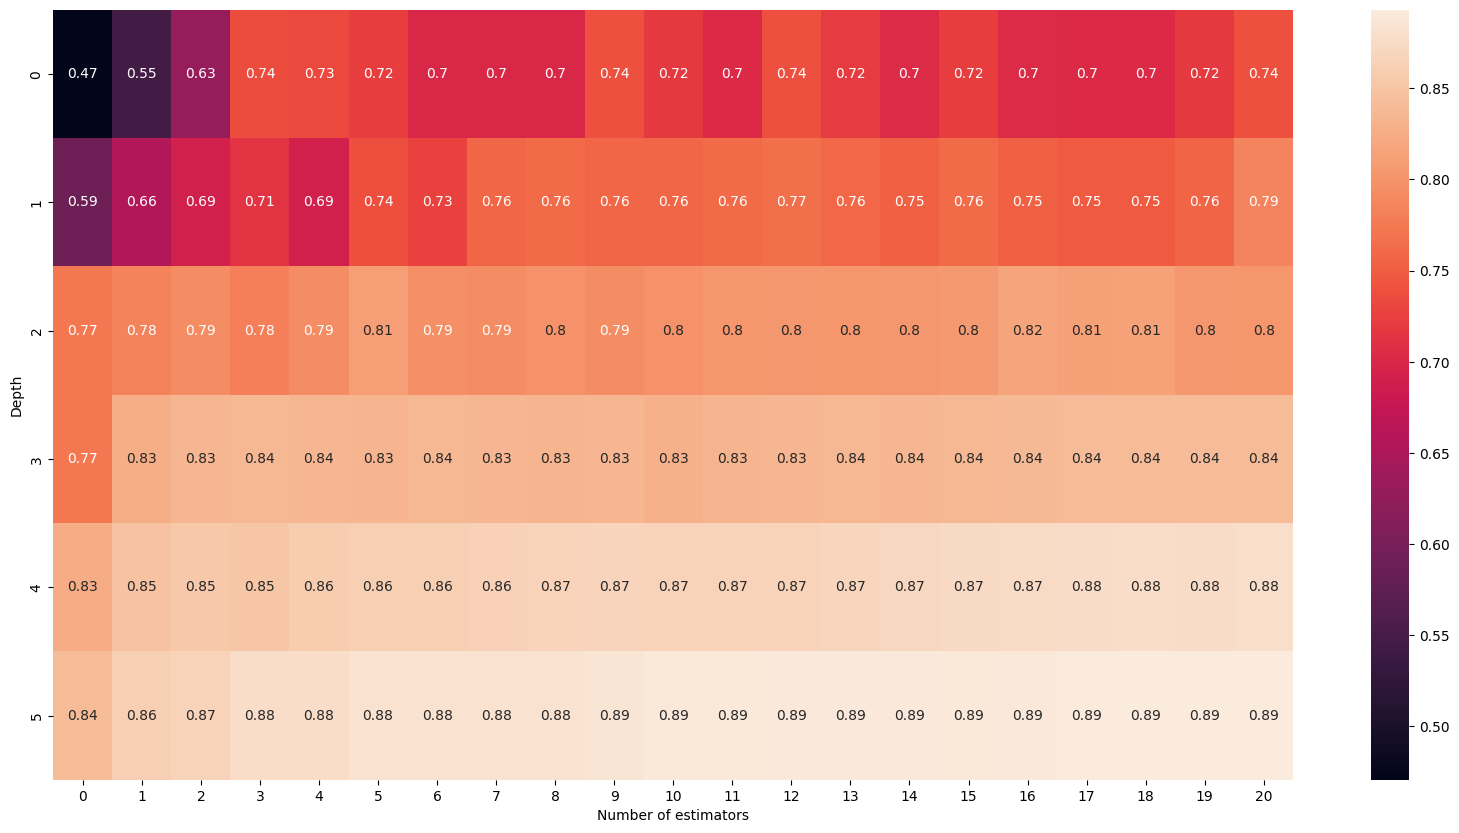

In [16]:
entropy_sqrt_scores = models_testing.fit_test_RFC(X_train, y_train, X_test, y_test, 'entropy', 'sqrt')
metrics_tools.plot_RFC(entropy_sqrt_scores)

In [17]:
# Actual model implementation
RFC = RandomForestClassifier( 
        max_depth = 6, # Number of levels in each of the DT
        criterion = 'entropy', # Impurity function used
        n_estimators = 21, # Number of trees in the forest
        min_impurity_decrease = 0.001, # Minimum decrease in impurity for being selected as splitting feature/value
        max_features = 'sqrt', # Number of features to use with each of the decision tree
        random_state = 0
        ) 
RFC.fit(X_train, y_train)
y_pred = RFC.predict(X_test)

### Decision Tree

This Decision tree is made in order to compare the performance w.r.t. the Random forest classifier. Also here, grid search is performed before implementing the actual model in order to find the best depth hyperparameter.

In [ ]:
DTC_scores, cv_scores_mean, cv_scores_std = models_testing.fit_test_DTC(X_train, y_train, X_test, y_test)
metrics_tools.plot_DTC(DTC_scores, cv_scores_mean, cv_scores_std)

In [ ]:
# Actual model implementation
DTC = tree.DecisionTreeClassifier(
    random_state = 0,
    max_depth = 9,
    criterion = 'entropy',
    min_impurity_decrease = 0.001,
    )
DTC.fit(X_train, y_train) 
y_pred = DTC.predict(X_test)

#### Confusion matrix

In [ ]:
# Choose just one of the two model before printing the confusion matrix
metrics_tools.plot_confusion_matrix(metrics.confusion_matrix(y_test, y_pred))